In [83]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM,Dense
from sklearn.preprocessing import MinMaxScaler
import copy

In [136]:
df = pd.read_csv('Dataset_2.csv')
df.head()
df

,Date,Closing Price
0,2020-02-29,8778.470511
1,2020-03-01,8639.591417
2,2020-03-02,8548.948322
3,2020-03-03,8923.044398
4,2020-03-04,8791.112058
...,...,...
361,2021-02-24,48172.877477
362,2021-02-25,48745.432984
363,2021-02-26,48291.412083
364,2021-02-27,45752.114919


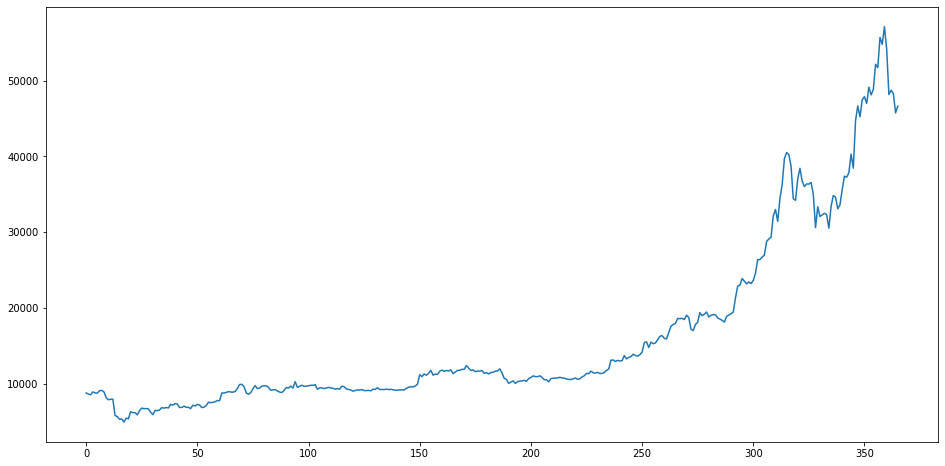

In [85]:
plt.figure(figsize=(16,8))
plt.plot(df["Closing Price"],label='Close Price history')


In [86]:

data = df.filter(['Closing Price'])
dataset = data.values
training_data_len = math.ceil(len(dataset)*.8)
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

In [87]:
train_data = scaled_data[0:training_data_len , : ]
x_train=[]
y_train = []
for i in range(60,len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

In [88]:
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [89]:
model = Sequential()
model.add(LSTM(units=50,activation='elu', return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50,activation='elu', return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size=10, epochs=100)

Epoch 1/100
24/24 [==============================] - 5s 48ms/step - loss: 0.0063
Epoch 2/100
24/24 [==============================] - 1s 50ms/step - loss: 6.1511e-04
Epoch 3/100
24/24 [==============================] - 1s 47ms/step - loss: 3.3482e-04
Epoch 4/100
24/24 [==============================] - 1s 48ms/step - loss: 2.0987e-04
Epoch 5/100
24/24 [==============================] - 1s 48ms/step - loss: 1.7169e-04
Epoch 6/100
24/24 [==============================] - 1s 49ms/step - loss: 1.5367e-04
Epoch 7/100
24/24 [==============================] - 1s 46ms/step - loss: 1.9017e-04
Epoch 8/100
24/24 [==============================] - 1s 46ms/step - loss: 1.7579e-04
Epoch 9/100
24/24 [==============================] - 1s 50ms/step - loss: 2.2640e-04
Epoch 10/100
24/24 [==============================] - 1s 47ms/step - loss: 1.6012e-04
Epoch 11/100
24/24 [==============================] - 1s 47ms/step - loss: 1.6413e-04
Epoch 12/100
24/24 [==============================] - 1s 47ms/step 

Epoch 96/100
24/24 [==============================] - 1s 45ms/step - loss: 7.6690e-05
Epoch 97/100
24/24 [==============================] - 1s 46ms/step - loss: 1.0211e-04
Epoch 98/100
24/24 [==============================] - 1s 46ms/step - loss: 1.1410e-04
Epoch 99/100
24/24 [==============================] - 1s 47ms/step - loss: 7.6063e-05
Epoch 100/100
24/24 [==============================] - 1s 53ms/step - loss: 8.3876e-05


In [90]:
test_data = scaled_data[training_data_len - 60: , : ]
x_test = []
y_test =  dataset[training_data_len : , : ]
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])

In [91]:
x_test = np.array(x_test)

In [92]:
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

In [93]:
predictions = model.predict(x_test) 
predictions = scaler.inverse_transform(predictions)

C:\Users\tkksc\anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


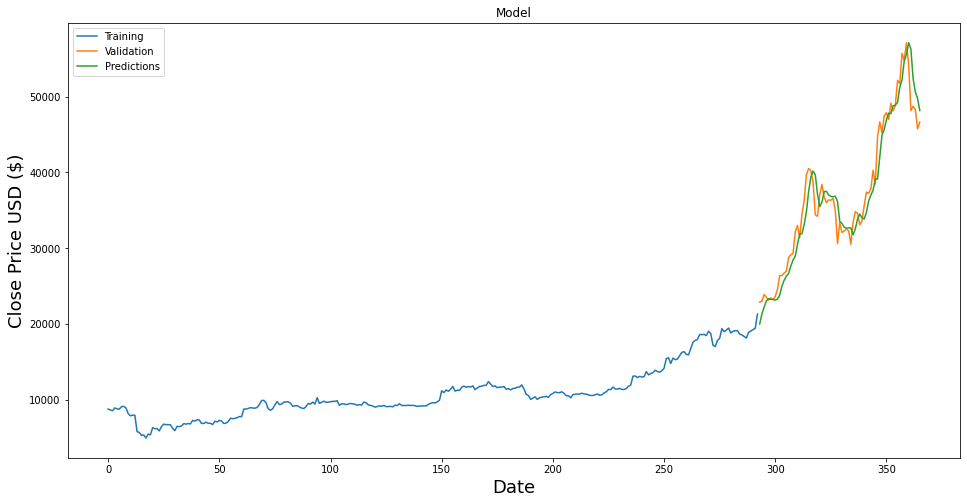

In [94]:
train = data[:training_data_len]
valid = data[training_data_len:]
fut_pred = copy.deepcopy(valid)
valid['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Closing Price'])
plt.plot(valid[['Closing Price', 'Predictions']])
plt.legend(['Training', 'Validation', 'Predictions'], loc='upper left')
plt.show()

In [95]:
def moving_test_window_preds(start, n_future_preds):
    
    prediction = [] 
    moving_input_window = []

    inputs = fut_pred.reset_index(drop=True).values
    inputs = scaler.transform(inputs)

    moving_input_window.append(inputs[start:(start+60), :])
    moving_input_window = np.array(moving_input_window)
    moving_input_window = np.reshape(moving_input_window, (moving_input_window.shape[0], moving_input_window.shape[1], 1))

    for i in range(n_future_preds):

        y_hat = model.predict(moving_input_window)

        prediction.append(y_hat[0,:])

        y_hat = y_hat.reshape(1,1,1) 

        moving_input_window = np.concatenate((moving_input_window, y_hat),axis=1)

    
    return prediction

In [124]:
valid.shape

(73, 2)

In [139]:
prediction = moving_test_window_preds(0,50)

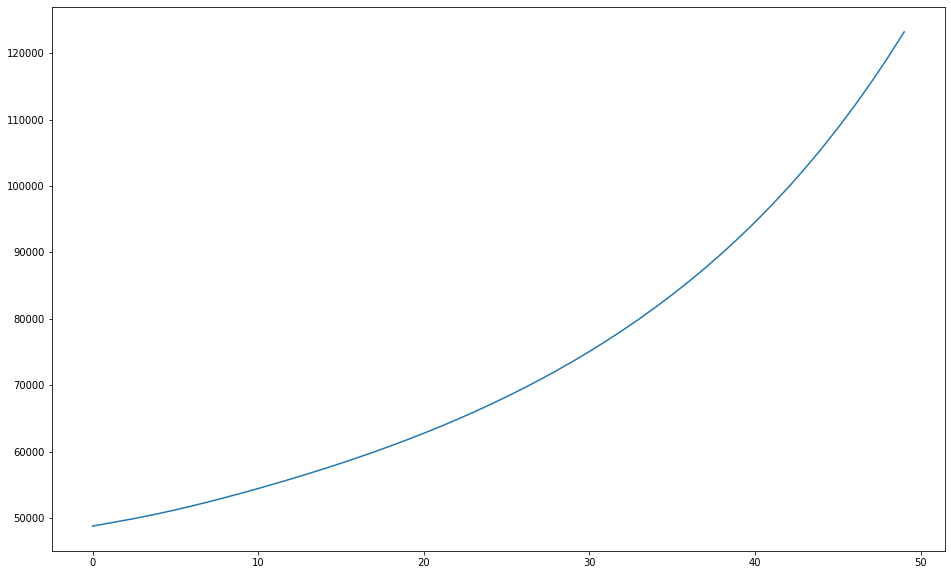

In [140]:
plt.figure(figsize=(16,10))
plt.plot(prediction)